In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings;
warnings.filterwarnings('ignore');
import spacy
import re
from nltk.tokenize import regexp_tokenize,TweetTokenizer
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from spacy.tokens import Span,Token
nlp = spacy.load('en_core_web_md')
pd.set_option('display.max_colwidth', -1)
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
import string

In [2]:
df_raw = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_raw.head()
#If the tweet is disaster related then target = 1, or else 0

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df_raw.info()
#Location information is absent in lot of cases

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_raw.target.value_counts(normalize=True)
#Not an imbalanced dataset

0    0.57034
1    0.42966
Name: target, dtype: float64

In [6]:
df_raw.keyword.value_counts(dropna=False)[:10]

NaN            61
fatalities     45
armageddon     42
deluge         42
body%20bags    41
sinking        41
damage         41
harm           41
collided       40
fear           40
Name: keyword, dtype: int64

In [7]:
df_raw.keyword.str.contains('%20').value_counts(normalize = True)

False    0.845736
True     0.154264
Name: keyword, dtype: float64

In [8]:
df_test.keyword.str.contains('%20').value_counts(normalize = True)

False    0.834106
True     0.165894
Name: keyword, dtype: float64

In [9]:
#Replacing %20 with spaces
df_raw['keyword'] = df_raw.keyword.str.replace('%20', ' ')
df_test['keyword'] = df_test.keyword.str.replace('%20', ' ')

In [10]:
df_raw[df_raw.target == 1].\
keyword.value_counts(dropna=False)[:20]

NaN                  42
wreckage             39
outbreak             39
derailment           39
typhoon              37
oil spill            37
debris               37
rescuers             32
suicide bomb         32
evacuated            32
suicide bombing      32
nuclear disaster     31
razed                31
suicide bomber       30
earthquake           30
airplane accident    30
bridge collapse      29
collision            29
wildfire             29
buildings on fire    28
Name: keyword, dtype: int64

In [11]:
df_raw[df_raw.target == 0].\
keyword.value_counts(dropna=False)[:20]

body bags      40
harm           37
armageddon     37
wrecked        36
deluge         36
ruin           36
siren          35
fear           35
twister        35
explode        35
panic          34
aftershock     34
screaming      34
crush          33
blaze          33
traumatised    33
sinking        33
blizzard       33
blazing        33
curfew         32
Name: keyword, dtype: int64

While the keywords for disaster tweets are specific, keywords for non disaster tweets are those which can be used in different context. May be keyword can be used later

In [12]:
#df_raw.keyword.unique()

In [13]:
df_raw[df_raw.target == 1].\
location.isna().value_counts(normalize = True)

False    0.671354
True     0.328646
Name: location, dtype: float64

In [14]:
df_raw[df_raw.target == 0].\
location.isna().value_counts(normalize = True)

False    0.66421
True     0.33579
Name: location, dtype: float64

Presence or absence of location is not much of a factor.

In [15]:
df_raw[df_raw.target == 1].\
location.value_counts(normalize = True)[:10]

USA               0.030510
United States     0.012295
Nigeria           0.010018
India             0.009107
Mumbai            0.008652
UK                0.007286
New York          0.007286
London            0.007286
Washington, DC    0.006831
Canada            0.005920
Name: location, dtype: float64

In [16]:
df_raw[df_raw.target == 0].\
location.value_counts(normalize = True)[:10]

New York           0.019071
USA                0.012829
London             0.010055
United States      0.007975
Los Angeles, CA    0.006241
Canada             0.005548
Kenya              0.005201
Everywhere         0.004161
Florida            0.003814
UK                 0.003814
Name: location, dtype: float64

In [17]:
df_raw['len_twt'] = df_raw.text.str.len()
print(df_raw.len_twt.describe())

count    7613.000000
mean     101.037436 
std      33.781325  
min      7.000000   
25%      78.000000  
50%      107.000000 
75%      133.000000 
max      157.000000 
Name: len_twt, dtype: float64


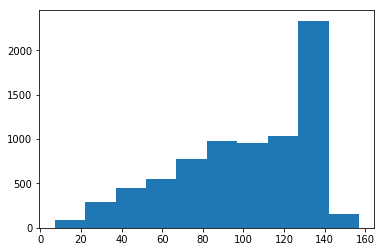

In [18]:
plt.hist(df_raw.len_twt);

In [19]:
def hashtag_extract(text):
    return [hashtag.lower() for hashtag in re.findall(r'#([A-Za-z0-9]+)',text)]

def hashtag_count(text):
    return len([hashtag.lower() for hashtag in re.findall(r'#([A-Za-z0-9]+)',text)])

def handle_extract(text):
    return re.findall(r'@([A-Za-z0-9_]+)',text)

def handle_count(text):
    return len(re.findall(r'@([A-Za-z0-9_]+)',text))

In [20]:
df_raw['hashtags'] = df_raw.text.apply(hashtag_extract)
df_raw['hashtag_count'] = df_raw.text.apply(hashtag_count)
df_raw['handles'] = df_raw.text.apply(handle_extract)
df_raw['handle_count'] = df_raw.text.apply(handle_count)

df_test['hashtags'] = df_test.text.apply(hashtag_extract)
df_test['hashtag_count'] = df_test.text.apply(hashtag_count)
df_test['handles'] = df_test.text.apply(handle_extract)
df_test['handle_count'] = df_test.text.apply(handle_count)

In [21]:
(df_raw[df_raw.target ==1].hashtag_count != 0).\
value_counts(normalize = True)

False    0.737695
True     0.262305
Name: hashtag_count, dtype: float64

In [22]:
(df_raw[df_raw.target ==0].hashtag_count != 0).\
value_counts(normalize = True)

False    0.796177
True     0.203823
Name: hashtag_count, dtype: float64

Disaster tweets in general have more hashtags than non disaster tweets

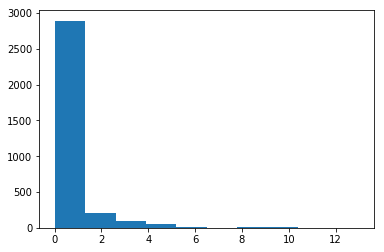

In [23]:
plt.hist(df_raw[df_raw.target ==1].hashtag_count);

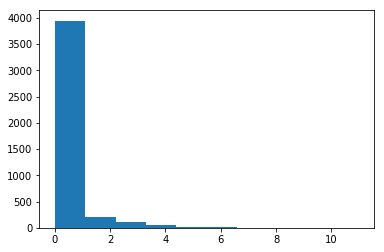

In [24]:
plt.hist(df_raw[df_raw.target ==0].hashtag_count);

In [25]:
def plot_most_common_words(dataframe,col_name,num_words):
    word_counter = Counter(dataframe[col_name].sum()).most_common(num_words)
    words = [word for word,count in word_counter]
    counts = [count for word,count in word_counter]
    fig, ax = plt.subplots(figsize=(15,4))
    sns.barplot(x = words, y = counts);
    plt.tight_layout()
    #print(word_counter)

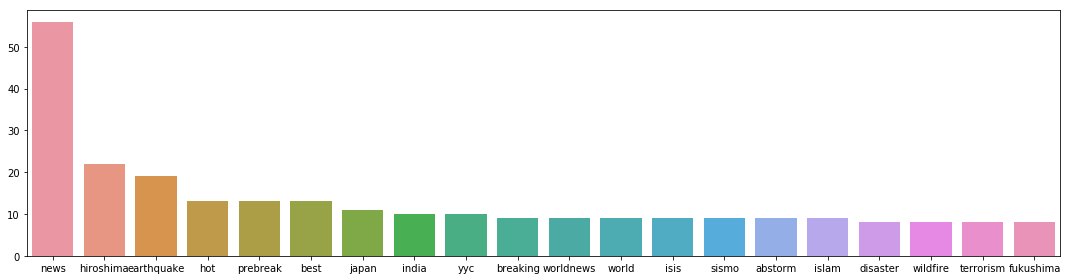

In [26]:
plot_most_common_words(df_raw[df_raw.target == 1], 'hashtags', 20)

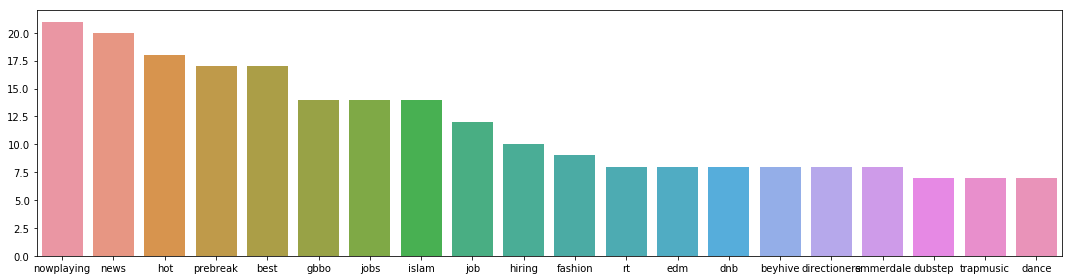

In [27]:
plot_most_common_words(df_raw[df_raw.target == 0], 'hashtags', 20)

In [28]:
def hashtag_word_separator(text):
    hashtags = re.findall(r'#([A-Za-z0-9]+)', text)#re.findall(r'#(\S+)', text)
    for tag in hashtags:
        if (re.match(r'[A-Z][^A-Z]+[A-Z]',tag ))!= None:
            #tag = re.sub('[^A-Za-z0-9]+', '', tag)#(for extreme cases like index 337, 2534 where hashtag followed by )
            replacement = " ".join(re.findall(r'[A-Z][a-z]+',tag))
            text = re.sub('#'+tag, replacement, text)
    return text

def url_remover(text):
    return re.sub (r'www\S+|https?\S+','', text)

def twt_handle_remover(text):#Has not been used
    return re.sub (r'@\S+','', text)

def special_char_num_remover(text):
    return re.sub(r'[^A-Z^a-z^\s^\']',' ', text)

def tweet_cleaner(text):
    return special_char_num_remover((url_remover(hashtag_word_separator(text))))

In [29]:
df_raw['clean_tweet'] = df_raw.text.apply(tweet_cleaner)
df_test['clean_tweet'] = df_test.text.apply(tweet_cleaner)

In [30]:
def twt_tokenizer(text):
    return [t for t in word_tokenize(text.lower()) if t not in nlp.Defaults.stop_words  and t!= '\'']#can't, won't

In [31]:
df_raw['nltk_nostop_lowercase_tokens'] = df_raw.clean_tweet.apply(twt_tokenizer)
df_test['nltk_nostop_lowercase_tokens'] = df_test.clean_tweet.apply(twt_tokenizer)

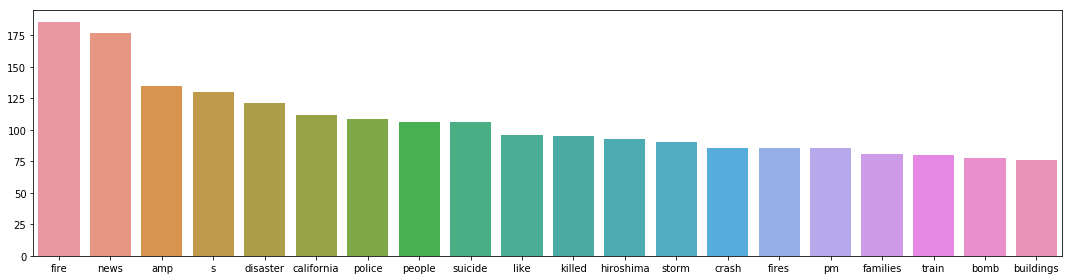

In [32]:
plot_most_common_words(df_raw[df_raw.target == 1], 'nltk_nostop_lowercase_tokens', 20)

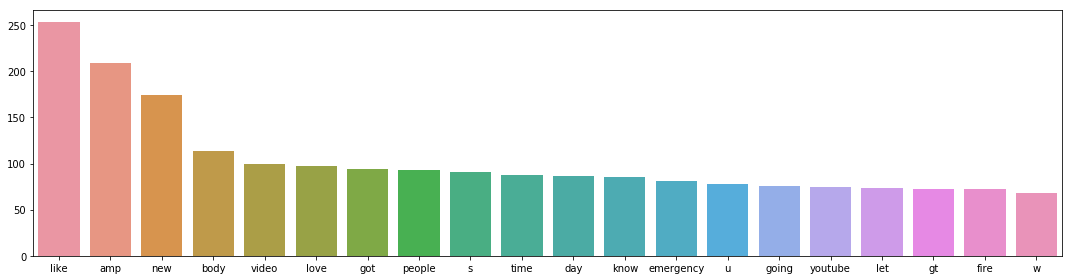

In [33]:
plot_most_common_words(df_raw[df_raw.target == 0], 'nltk_nostop_lowercase_tokens', 20)

In [34]:
df_trn, df_val, _, _ = train_test_split(df_raw, df_raw['target'],test_size=0.33,stratify = df_raw['target'] ,random_state=42)

In [35]:
df_trn.head()

,id,keyword,location,text,target,len_twt,hashtags,hashtag_count,handles,handle_count,clean_tweet,nltk_nostop_lowercase_tokens
854,1236,blood,"???????, ??'??????",Blood Group A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....,0,108,[],0,[],0,Blood Group A ve is associated with Gastric Carcinoma says text book Another fragile gene in my body,"[blood, group, ve, associated, gastric, carcinoma, says, text, book, fragile, gene, body]"
5663,8081,rescue,Thornton Colorado,Tell the United Nations: Plantations are NOT forests! https://t.co/cic7h64Qv8 via @RainforestResq,0,97,[],0,[RainforestResq],1,Tell the United Nations Plantations are NOT forests via RainforestResq,"[tell, united, nations, plantations, forests, rainforestresq]"
2411,3470,derailed,USA,@stury Note there were no passengers on board when the train derailed this morning.,1,83,[],0,[stury],1,stury Note there were no passengers on board when the train derailed this morning,"[stury, note, passengers, board, train, derailed, morning]"
3611,5154,fatal,NaN,Investigators shift focus to cause of fatal Waimate fire http://t.co/aDSvDpNP3r,1,79,[],0,[],0,Investigators shift focus to cause of fatal Waimate fire,"[investigators, shift, focus, cause, fatal, waimate, fire]"
581,840,bioterror,"Phoenix, AZ",FedEx to stop transporting bioterror germs after lab mishaps: FedEx has stopped transporting certain research ... http://t.co/y3dM9uLqxG,1,136,[],0,[],0,FedEx to stop transporting bioterror germs after lab mishaps FedEx has stopped transporting certain research,"[fedex, stop, transporting, bioterror, germs, lab, mishaps, fedex, stopped, transporting, certain, research]"


In [36]:
df_test.head()

,id,keyword,location,text,hashtags,hashtag_count,handles,handle_count,clean_tweet,nltk_nostop_lowercase_tokens
0,0,NaN,NaN,Just happened a terrible car crash,[],0,[],0,Just happened a terrible car crash,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",[earthquake],1,[],0,Heard about earthquake is different cities stay safe everyone,"[heard, earthquake, different, cities, stay, safe]"
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",[],0,[],0,there is a forest fire at spot pond geese are fleeing across the street I cannot save them all,"[forest, fire, spot, pond, geese, fleeing, street, save]"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[spokane, wildfires]",2,[],0,Apocalypse lighting Spokane wildfires,"[apocalypse, lighting, spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,[],0,[],0,Typhoon Soudelor kills in China and Taiwan,"[typhoon, soudelor, kills, china, taiwan]"


In [37]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(df_trn.clean_tweet)
tfidf_val = tfidf_vectorizer.transform(df_val.clean_tweet)
tfidf_test = tfidf_vectorizer.transform(df_test.clean_tweet)

In [58]:
nb_classifier_tfidf = MultinomialNB()
nb_classifier_tfidf.fit(tfidf_train,df_trn.target)
df_val['NB_Tfidf'] = nb_classifier_tfidf.predict(tfidf_val)
df_test['NB_Tfidf'] = nb_classifier_tfidf.predict(tfidf_test)
NB_tfidf_score = metrics.f1_score(df_val['target'],df_val['NB_Tfidf'])
print(NB_tfidf_score)

0.7500000000000001


In [57]:
logreg_classifier_tfidf = LogisticRegression()
logreg_classifier_tfidf.fit(tfidf_train,df_trn.target)
df_val['Logreg_Tfidf'] = logreg_classifier_tfidf.predict(tfidf_val)
df_test['Logreg_Tfidf'] = logreg_classifier_tfidf.predict(tfidf_test)
logreg_tfidf_score = metrics.f1_score(df_val['target'],df_val['Logreg_Tfidf'])
print(logreg_tfidf_score)

0.7505175983436854


In [56]:
df_val['NB_LR_combo'] = (df_val.Logreg_Tfidf + df_val.NB_Tfidf).astype(bool).astype(int)
NB_LR_comb_score = metrics.f1_score(df_val['target'],df_val['NB_LR_combo'])
print(NB_LR_comb_score)

0.7591674925668979


In [41]:
df_NB_Tfidf = pd.DataFrame({'id':df_test['id'],'target':df_test['NB_Tfidf']})
#df_NB_Tfidf.to_csv('clean_twt_hashtag_separator_handles_presnt_NB_tfidf.csv',index = False)

In [42]:
df_Logreg_Tfidf = pd.DataFrame({'id':df_test['id'],'target':df_test['Logreg_Tfidf']})
#df_Logreg_Tfidf.to_csv('clean_twt_hashtag_separate_handles_present_Logreg_tfidf.csv',index = False)

In [43]:
df_Logreg_Tfidf_47 = pd.DataFrame({'id':df_test['id'],'target':(logreg_classifier_tfidf.predict_proba(tfidf_test)[:,1]>0.47).astype(int)})
#df_Logreg_Tfidf.to_csv('clean_twt_hashtag_separate_handles_present_Logreg_tfidf_0.47_threshold.csv',index = False)

In [59]:
metrics.f1_score(df_val['target'],(logreg_classifier_tfidf.predict_proba(tfidf_val)[:,1]>0.47).astype(int))

0.7644135188866799

In [45]:
(df_val.Logreg_Tfidf != df_val.NB_Tfidf).value_counts()

False    2369
True     144 
dtype: int64

In [52]:
tn, fp, fn, tp = metrics.confusion_matrix(df_val.target,df_val['NB_LR_combo']).ravel()
tn, fp, fn, tp

(1261, 172, 314, 766)

In [47]:
tn, fp, fn, tp = metrics.confusion_matrix(df_val.target,df_val.Logreg_Tfidf).ravel()
tn, fp, fn, tp

(1306, 127, 355, 725)

In [48]:
(df_val.Logreg_Tfidf + df_val.NB_Tfidf).value_counts()

0    1575
2    794 
1    144 
dtype: int64

In [49]:
df_diagnostics = df_val[df_val.target != df_val.NB_Tfidf][['text','clean_tweet','target','NB_Tfidf']]

In [50]:
df_diagnostics[df_diagnostics.target == 0].sample(n = 10)[['text','clean_tweet']]

,text,clean_tweet
7447,@mattmosley post a pic of your wounds please,mattmosley post a pic of your wounds please
2416,Has #IdentityTheft Derailed Your #TaxReturn? \n8 Steps for Cleaning Up an #IdentityTheft Train Wreck. #CRI\nhttp://t.co/gxQWD1qZBd,Has Identity Theft Derailed Your Tax Return \n Steps for Cleaning Up an Identity Theft Train Wreck CRI\n
4249,@rawfoodbliss I'm in the middle of a humid heat wave and a patch on my forehead flared up. I take olive oli extract and 4 tbs olive oil,rawfoodbliss I'm in the middle of a humid heat wave and a patch on my forehead flared up I take olive oli extract and tbs olive oil
1823,@johndcgow heard this few days ago while driving and near crashed the car from laughing to much,johndcgow heard this few days ago while driving and near crashed the car from laughing to much
6703,L B #Oklahoma #Thunder DURANT NBA ADIDAS OKLAHOMA CITY THUNDER YOUTH LARGE SWINGMAN JERSEY RETAIL $75 #NBA #Durant http://t.co/T81oayjoWC,L B Oklahoma Thunder DURANT NBA ADIDAS OKLAHOMA CITY THUNDER YOUTH LARGE SWINGMAN JERSEY RETAIL NBA Durant
5463,.@slosheriff: 2 South Gate police officers and 2 Huntington Park officers arrested after child abuse investigation at boot camp,slosheriff South Gate police officers and Huntington Park officers arrested after child abuse investigation at boot camp
2086,@AtchisonSean he is dead,AtchisonSean he is dead
4912,Is this the creepiest youth camp ever?. http://t.co/T8uqm7Imir,Is this the creepiest youth camp ever
120,#WisdomWed BONUS - 5 Minute Daily Habits that could really improve your life. How many do you already do? #lifehacks http://t.co/TBm9FQb8cW,Wisdom Wed BONUS Minute Daily Habits that could really improve your life How many do you already do lifehacks
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,hot C specially modified to land in a stadium and rescue hostages in Iran in prebreak best


In [51]:
df_diagnostics[df_diagnostics.target == 1].sample(n = 10)[['text','clean_tweet']]

,text,clean_tweet
4332,Plans by former First Lady and wife of ex-President Goodluck Jonathan Dame Patience Jonathan to hijack the All... http://t.co/HaShGQAFic,Plans by former First Lady and wife of ex President Goodluck Jonathan Dame Patience Jonathan to hijack the All
1891,Man crushed to death by own car http://t.co/CrPO9DkW9v,Man crushed to death by own car
5114,Chernobyl disaster - Wikipedia the free encyclopedia don't you just love the nuclear technology it's so glorious https://t.co/GHucazjSxB,Chernobyl disaster Wikipedia the free encyclopedia don't you just love the nuclear technology it's so glorious
5772,Riot police intervene after Southampton and Vitesse Arnhem supporters clash: Û¢ Fans clash in buildup to second... http://t.co/sKVNmtZGeG,Riot police intervene after Southampton and Vitesse Arnhem supporters clash Fans clash in buildup to second
7218,Agreed there - especially on automatic weapons. There's no legitimate reason for needing one @Argus_99 @HeidiA1438,Agreed there especially on automatic weapons There's no legitimate reason for needing one Argus HeidiA
3254,@godsfirstson1 and she wrapped his coat around herself. It practically engulfed her.,godsfirstson and she wrapped his coat around herself It practically engulfed her
4318,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',The Prophet peace be upon him said 'Save yourself from Hellfire even if it is by giving half a date in charity '
7292,This past week has been an absolute whirlwind.... Athens bound,This past week has been an absolute whirlwind Athens bound
1207,Messi: has tattoos so he can't donate blood\nRonaldo: runs into burning buildings to save dogs #respect,Messi has tattoos so he can't donate blood\nRonaldo runs into burning buildings to save dogs respect
6925,Strawberries are in big trouble. Scientists race to find solution. http://t.co/MqydXRLae7 http://t.co/EpJjkB4Be9,Strawberries are in big trouble Scientists race to find solution


In [55]:
count_vectorizer_bigram = CountVectorizer(stop_words='english',ngram_range=(1, 2))
count_train_bigram = count_vectorizer_bigram.fit_transform(df_trn.clean_tweet)
count_val_bigram = count_vectorizer_bigram.transform(df_val.clean_tweet)
count_test_bigram = count_vectorizer_bigram.transform(df_test.clean_tweet)

nb_classifier_count_bigram = MultinomialNB()
nb_classifier_count_bigram.fit(count_train_bigram,df_trn.target)
df_val['NB_Count_bigram'] = nb_classifier_count_bigram.predict(count_val_bigram)
df_test['NB_Count_bigram'] = nb_classifier_count_bigram.predict(count_test_bigram)
NB_count_score_bigram = metrics.accuracy_score(df_val['target'],df_val['NB_Count_bigram'])
print(NB_count_score_bigram)

logreg_classifier_count_bigram = LogisticRegression()
logreg_classifier_count_bigram.fit(count_train_bigram,df_trn.target)
df_val['Logreg_Count_bigram'] = logreg_classifier_count_bigram.predict(count_val_bigram)
df_test['Logreg_Count_bigram'] = logreg_classifier_count_bigram.predict(count_test_bigram)
logreg_count_score_bigram = metrics.accuracy_score(df_val['target'],df_val['Logreg_Count_bigram'])
print(logreg_count_score_bigram)

0.7954635893354556
0.8058097890966972
